# Does cluster-packing save energy?
This notebook runs a workload at various frequencies. The workload is run both force-packed onto a single cluster and force-spread across two clusters, and the energy is compared.

The target configuration (with AEP configuration) should be in target.conf.

This assumes an SMP-like system e.g. HiKey, Pixel, with two clusters.

## Setup...

In [1]:
# Various setup, probably mostly unused

from env import TestEnv
import pandas as pd
import json
import os
from conf import LisaLogging
from bart.common.Utils import area_under_curve
from trappy.plotter import plot_trace
from IPython.display import display
from trappy import ILinePlot
from trappy.stats.grammar import Parser
from bart.sched.SchedMultiAssert import SchedMultiAssert
import pandas as pd
from trace import Trace
LisaLogging.setup()
import logging
logging.getLogger('Trace').setLevel(logging.ERROR)
logging.getLogger('Analysis').setLevel(logging.WARNING)
logging.getLogger('EnergyMeter').setLevel(logging.DEBUG)
%matplotlib inline
from platforms.juno_energy import juno_energy
from platforms.pixel_energy import pixel_energy
import tests.eas.generic
import numpy as np
from IPython.display import display
from wlgen import RTA, Periodic
from executor import Executor
from platforms.hikey_energy import hikey_energy
import numpy as np

2017-03-27 15:39:23,766 INFO    : root         : Using LISA logging configuration:
2017-03-27 15:39:23,767 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


In [2]:
# Some nonsense to get caiman to work on Brendan's computer
p = os.getenv('PATH').split(':')
caiman_path = '/opt/ds5_v5.23.0/bin'
if caiman_path not in p:
    p.insert(0, caiman_path)
    os.environ['PATH'] = ':'.join(p)

In [3]:
te = TestEnv(test_conf={
        'modules': ['cgroups'], 
        'ftrace': {
            'events': ['sched_switch', 'cpu_frequency', 'cpu_idle', 'sched_load_avg_cpu', 'sched_load_avg_task', 'irq*']
        }
    }, force_new=True)

2017-03-27 15:39:23,817 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2017-03-27 15:39:23,818 INFO    : TestEnv      : Loading default (file) target configuration
2017-03-27 15:39:23,819 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2017-03-27 15:39:23,821 DEBUG   : TestEnv      : Target configuration {u'username': u'linaro', u'emeter': {u'instrument': u'aep', u'channel_map': {u'BAT': u'BAT'}, u'conf': {u'resistor_values': [0.099], u'device_entry': u'/dev/ttyACM0'}}, u'rtapp-calib': {u'1': 250, u'0': 250, u'3': 250, u'2': 250, u'5': 250, u'4': 250, u'7': 250, u'6': 250}, u'modules': [], u'platform': u'android', u'board': u'hikey', u'exclude_modules': [], u'device': u'04D314DF000BC57F', u'__features__': u'no-kernel no-reboot', u'tftp': {u'kernel': u'kern.bin', u'folder': u'/var/lib/tftpboot', u'dtb': u'dtb.bin'}, u'password': u'linaro', u'tools': []}
2017-03-27 15:39:23,822 INFO    : TestEnv      : Loading cu

init_target_connection
get_connection
resolve_paths
install busybox
update_from_target
update_modules


2017-03-27 15:39:25,597 DEBUG   : TestEnv      : Checking target connection...
2017-03-27 15:39:25,599 DEBUG   : TestEnv      : Target info:
2017-03-27 15:39:25,600 DEBUG   : TestEnv      :       ABI: arm64
2017-03-27 15:39:25,601 DEBUG   : TestEnv      :      CPUs: CpuInfo(['A53', 'A53', 'A53', 'A53', 'A53', 'A53', 'A53', 'A53'])
2017-03-27 15:39:25,603 DEBUG   : TestEnv      :  Clusters: [0, 0, 0, 0, 0, 0, 0, 0]
2017-03-27 15:39:25,604 INFO    : TestEnv      : Initializing target workdir:
2017-03-27 15:39:25,605 INFO    : TestEnv      :    /data/local/tmp/devlib-target


install_modules


2017-03-27 15:39:27,997 INFO    : CGroups      : Available controllers:
2017-03-27 15:39:28,462 INFO    : CGroups      :   cpuset       : /data/local/tmp/devlib-target/cgroups/devlib_cgh5
2017-03-27 15:39:28,918 INFO    : CGroups      :   cpu          : /data/local/tmp/devlib-target/cgroups/devlib_cgh4
2017-03-27 15:39:29,369 INFO    : CGroups      :   cpuacct      : /data/local/tmp/devlib-target/cgroups/devlib_cgh1
2017-03-27 15:39:29,829 INFO    : CGroups      :   schedtune    : /data/local/tmp/devlib-target/cgroups/devlib_cgh2
2017-03-27 15:39:30,275 INFO    : CGroups      :   blkio        : /data/local/tmp/devlib-target/cgroups/devlib_cgh6
2017-03-27 15:39:30,721 INFO    : CGroups      :   memory       : /data/local/tmp/devlib-target/cgroups/devlib_cgh3
2017-03-27 15:39:31,198 INFO    : CGroups      :   devices      : /data/local/tmp/devlib-target/cgroups/devlib_cgh6
2017-03-27 15:39:31,692 INFO    : CGroups      :   freezer      : /data/local/tmp/devlib-target/cgroups/devlib_cgh6


In [4]:
# Some nonsense to make LISA treat HiKey with the respect it deserves
if te.conf['board'] == 'hikey':
    from trappy.stats.Topology import Topology
    hikey_topology = Topology(clusters=[[0, 1, 2, 3], [4, 5, 6, 7]])
    te.topology = hikey_topology
    te.platform['clusters'] = {'big': [0, 1, 2, 3], 'little': [4, 5, 6, 7]}

# Define Workloads
We're going to create two workloads with a handful of small tasks, such that they could fit onto a single cluster at the lowest OPP. 

To avoid evertying being thrown out by the periodiciy of the tasks, the start times and periods of the tasks are staggered.

We'll run this same workload both with and without using taskset to force them onto a single cluster.

In [5]:
def get_wloads(nrg_model, cpu=0, type='min', bandwidth_to_eat=0.25, ntasks=16):
    cpu_node = nrg_model.cpu_nodes[cpu]
    cluster_node = cpu_node.parent
    ncpus = len(cluster_node.cpus)
    if type == 'min':
        cpu_cap = cpu_node.min_capacity
    elif type == 'max':
        cpu_cap = cpu_node.max_capacity
        
    total_cap = bandwidth_to_eat * ncpus * cpu_cap
    target_task_cap = total_cap / ntasks
    task_pct = int((target_task_cap / 1024) * 100)
    task_cap = int(1024 * (task_pct / 100.))
    tasks_per_cpu = int(cpu_cap / task_cap)
    
    print 'Will create workloads with {} tasks each using {} capacity'.format(ntasks, task_cap)
    
    # Stagger the workloads so that they prevent shared idle states
    period_s = 10e-3
    stagger_s = 0.7e-3
    delays = np.arange(period_s, step=stagger_s)
    
    if len(delays) > ntasks:
        print "WARNING: not enough tasks to cover period with wakeups"
    
    # Figure out a set of CPUs that spans both clusters
    [cluster0, cluster1] = te.platform['clusters'].values()
    cpu_pairs = zip(cluster0, cluster1)
    print cluster0, cluster1, cpu_pairs
    cluster_spread_cpuset = reduce(lambda x, y: x + y, cpu_pairs[0:len(cpu_pairs) / 2])
    
    tasks = {}
    for i in range(ntasks):
        tasks['{}pct_{}'.format(task_pct, i)] = {
            'kind': 'Periodic',
            'params': {
                'duty_cycle_pct': task_pct,
                'period_ms' : period_s * 1e3 + (i - (ntasks / 2)),
                'delay_s' : delays[i % len(delays)],
                'duration_s': 3
            }
        }
    
    wloads = {
        'forced_pack': {
            'type': 'rt-app',
            'conf': {
                'class': 'profile',
                'params': tasks,
                'cpus': cluster0,
                'duration': 3,
            }
        },
        'break_packing': {
            'type': 'rt-app',
            'conf': {
                'class': 'profile',
                'params': tasks,
                'cpus': cluster_spread_cpuset,
                'duration': 3,
            }
        }
    }
        
    return wloads

In [6]:
wloads = get_wloads(te.nrg_model, type='max')

Will create workloads with 16 tasks each using 61 capacity
[0, 1, 2, 3] [4, 5, 6, 7] [(0, 4), (1, 5), (2, 6), (3, 7)]


# Run workloads
Now we'll run the workloads with the powersave governor

In [7]:
# Find frequencies that all CPUs can run at
shared_freqs = sorted(set.intersection(*[set(te.target.cpufreq.list_frequencies(c)) 
                                         for c in range(te.target.number_of_cpus)]))

In [8]:
executor = Executor(te, {
        'confs': [{
            'tag': 'freq_{}'.format(freq),
            'flags': ['ftrace', 'freeze_userspace'],
            'cpufreq': {
                'governor': 'userspace',
                'freqs': {cpu: freq for cpu in range(te.target.number_of_cpus)}
            },
        } for freq in shared_freqs[::len(shared_freqs)/5]],
        'wloads': wloads,
        'iterations': 5
    })

2017-03-27 15:39:36,274 INFO    : Executor     : Loading custom (inline) test configuration
2017-03-27 15:39:36,276 INFO    : Executor     : 
2017-03-27 15:39:36,277 INFO    : Executor     : ################################################################################
2017-03-27 15:39:36,278 INFO    : Executor     : Experiments configuration
2017-03-27 15:39:36,279 INFO    : Executor     : ################################################################################
2017-03-27 15:39:36,280 INFO    : Executor     : Configured to run:
2017-03-27 15:39:36,281 INFO    : Executor     :      5 target configurations:
2017-03-27 15:39:36,283 INFO    : Executor     :       freq_208000, freq_432000, freq_729000, freq_960000, freq_1200000
2017-03-27 15:39:36,284 INFO    : Executor     :      2 workloads (5 iterations each)
2017-03-27 15:39:36,285 INFO    : Executor     :       break_packing, forced_pack
2017-03-27 15:39:36,286 INFO    : Executor     : Total: 50 experiments
2017-03-27 15:39:

In [9]:
executor.run()

2017-03-27 15:39:39,085 INFO    : Executor     : 
2017-03-27 15:39:39,086 INFO    : Executor     : ################################################################################
2017-03-27 15:39:39,087 INFO    : Executor     : Experiments execution
2017-03-27 15:39:39,089 INFO    : Executor     : ################################################################################
2017-03-27 15:39:39,090 DEBUG   : TestEnv      : Dump platform descriptor in [/home/brejac01/sources/lisa/results/20170327_153935/platform.json]
2017-03-27 15:39:39,091 INFO    : Executor     : 
2017-03-27 15:39:39,092 INFO    : Executor     : ================================================================================
2017-03-27 15:39:39,094 INFO    : Executor     : configuring target for [freq_208000] experiments
2017-03-27 15:39:39,485 WARNING : Executor     : Setting target SELinux in permissive mode
2017-03-27 15:39:39,693 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor

2017-03-27 15:40:31,212 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:40:35,034 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.038766
2017-03-27 15:40:35,035 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:41:04,179 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:41:04,181 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/1/trace.dat
2017-03-27 15:41:04,182 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:41:04,183 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/1/trace_stat.json
2017-03-27 15:41:13,240 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:41:13,242 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:41:13,243 INFO    : Executor     : Experiment 1/50, [freq_208000:break_packing] 2/5
2017-03-27 15:41:13,513 INFO    : Wor

2017-03-27 15:41:48,074 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:41:51,864 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.039021
2017-03-27 15:41:51,866 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:42:20,871 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:42:20,873 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/2/trace.dat
2017-03-27 15:42:20,875 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:42:20,876 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/2/trace_stat.json
2017-03-27 15:42:29,815 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:42:29,816 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:42:29,817 INFO    : Executor     : Experiment 2/50, [freq_208000:break_packing] 3/5
2017-03-27 15:42:30,098 INFO    : Wor

2017-03-27 15:43:04,989 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:43:08,888 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.038670
2017-03-27 15:43:08,889 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:43:38,724 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:43:38,725 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/3/trace.dat
2017-03-27 15:43:38,725 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:43:38,726 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/3/trace_stat.json
2017-03-27 15:43:47,841 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:43:47,843 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:43:47,844 INFO    : Executor     : Experiment 3/50, [freq_208000:break_packing] 4/5
2017-03-27 15:43:48,129 INFO    : Wor

2017-03-27 15:44:23,200 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:44:27,021 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.039123
2017-03-27 15:44:27,023 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:44:56,097 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:44:56,099 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/4/trace.dat
2017-03-27 15:44:56,100 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:44:56,102 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/4/trace_stat.json
2017-03-27 15:45:05,202 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:45:05,204 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:45:05,206 INFO    : Executor     : Experiment 4/50, [freq_208000:break_packing] 5/5
2017-03-27 15:45:05,487 INFO    : Wor

2017-03-27 15:45:39,933 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:45:43,767 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.039695
2017-03-27 15:45:43,768 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:46:12,480 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:46:12,482 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/5/trace.dat
2017-03-27 15:46:12,483 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:46:12,484 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/5/trace_stat.json
2017-03-27 15:46:21,584 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:46:21,586 INFO    : Workload     : Setup new workload forced_pack
2017-03-27 15:46:22,038 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-27 15:46:22,040 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-27 15:46:22,041

2017-03-27 15:46:57,532 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:47:01,304 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.038473
2017-03-27 15:47:01,305 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:47:30,620 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:47:30,622 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/1/trace.dat
2017-03-27 15:47:30,623 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:47:30,624 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/1/trace_stat.json
2017-03-27 15:47:39,775 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:47:39,777 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:47:39,778 INFO    : Executor     : Experiment 6/50, [freq_208000:forced_pack] 2/5
2017-03-27 15:47:40,061 INFO    : Workload 

2017-03-27 15:48:15,729 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:48:19,590 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.038950
2017-03-27 15:48:19,591 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:48:48,764 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:48:48,766 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/2/trace.dat
2017-03-27 15:48:48,767 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:48:48,769 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/2/trace_stat.json
2017-03-27 15:48:57,875 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:48:57,877 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:48:57,879 INFO    : Executor     : Experiment 7/50, [freq_208000:forced_pack] 3/5
2017-03-27 15:48:58,179 INFO    : Workload 

2017-03-27 15:49:33,043 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:49:36,854 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.038751
2017-03-27 15:49:36,856 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:50:06,092 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:50:06,094 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/3/trace.dat
2017-03-27 15:50:06,096 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:50:06,097 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/3/trace_stat.json
2017-03-27 15:50:15,328 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:50:15,330 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:50:15,331 INFO    : Executor     : Experiment 8/50, [freq_208000:forced_pack] 4/5
2017-03-27 15:50:15,600 INFO    : Workload 

2017-03-27 15:50:50,552 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:50:54,360 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.038896
2017-03-27 15:50:54,362 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:51:23,578 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:51:23,580 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/4/trace.dat
2017-03-27 15:51:23,582 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:51:23,583 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/4/trace_stat.json
2017-03-27 15:51:32,877 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:51:32,879 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:51:32,881 INFO    : Executor     : Experiment 9/50, [freq_208000:forced_pack] 5/5
2017-03-27 15:51:33,152 INFO    : Workload 

2017-03-27 15:52:08,074 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:52:11,926 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.039623
2017-03-27 15:52:11,928 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:52:40,887 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:52:40,889 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/5/trace.dat
2017-03-27 15:52:40,890 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:52:40,891 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/5/trace_stat.json
2017-03-27 15:52:50,114 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:52:50,116 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-27 15:52:50,882 INFO    : Executor     : 
2017-03-27 15:52:50,884 INFO    : Executor     : ==============================================================================

2017-03-27 15:53:20,614 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:53:24,164 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.036089
2017-03-27 15:53:24,165 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:53:38,306 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:53:38,308 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/1/trace.dat
2017-03-27 15:53:38,310 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:53:38,311 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/1/trace_stat.json
2017-03-27 15:53:43,350 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:53:43,352 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:53:43,353 INFO    : Executor     : Experiment 11/50, [freq_432000:break_packing] 2/5
2017-03-27 15:53:43,504 INFO    : Wo

2017-03-27 15:54:02,096 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:54:05,682 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.036075
2017-03-27 15:54:05,684 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:54:19,412 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:54:19,414 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/2/trace.dat
2017-03-27 15:54:19,415 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:54:19,416 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/2/trace_stat.json
2017-03-27 15:54:24,212 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:54:24,214 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:54:24,215 INFO    : Executor     : Experiment 12/50, [freq_432000:break_packing] 3/5
2017-03-27 15:54:24,370 INFO    : Wo

2017-03-27 15:54:42,768 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:54:46,325 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.035989
2017-03-27 15:54:46,326 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:55:00,732 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:55:00,734 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/3/trace.dat
2017-03-27 15:55:00,735 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:55:00,736 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/3/trace_stat.json
2017-03-27 15:55:05,662 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:55:05,664 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:55:05,665 INFO    : Executor     : Experiment 13/50, [freq_432000:break_packing] 4/5
2017-03-27 15:55:05,816 INFO    : Wo

2017-03-27 15:55:24,048 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:55:27,588 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.035761
2017-03-27 15:55:27,590 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:55:41,251 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:55:41,252 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/4/trace.dat
2017-03-27 15:55:41,253 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:55:41,254 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/4/trace_stat.json
2017-03-27 15:55:46,160 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:55:46,162 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:55:46,163 INFO    : Executor     : Experiment 14/50, [freq_432000:break_packing] 5/5
2017-03-27 15:55:46,319 INFO    : Wo

2017-03-27 15:56:04,645 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:56:08,235 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.036888
2017-03-27 15:56:08,237 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:56:22,222 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:56:22,224 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/5/trace.dat
2017-03-27 15:56:22,225 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:56:22,226 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/5/trace_stat.json
2017-03-27 15:56:27,231 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:56:27,233 INFO    : Workload     : Setup new workload forced_pack
2017-03-27 15:56:27,482 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-27 15:56:27,484 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-27 15:56:27,485

2017-03-27 15:56:46,564 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:56:50,107 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.035761
2017-03-27 15:56:50,108 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:57:04,349 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:57:04,352 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/1/trace.dat
2017-03-27 15:57:04,353 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:57:04,354 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/1/trace_stat.json
2017-03-27 15:57:09,359 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:57:09,361 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:57:09,363 INFO    : Executor     : Experiment 16/50, [freq_432000:forced_pack] 2/5
2017-03-27 15:57:09,518 INFO    : Workload

2017-03-27 15:57:28,110 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:57:31,691 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.036084
2017-03-27 15:57:31,693 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:57:45,796 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:57:45,798 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/2/trace.dat
2017-03-27 15:57:45,800 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:57:45,801 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/2/trace_stat.json
2017-03-27 15:57:50,655 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:57:50,657 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:57:50,657 INFO    : Executor     : Experiment 17/50, [freq_432000:forced_pack] 3/5
2017-03-27 15:57:50,810 INFO    : Workload

2017-03-27 15:58:09,367 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:58:12,922 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.036315
2017-03-27 15:58:12,923 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:58:27,031 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:58:27,033 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/3/trace.dat
2017-03-27 15:58:27,035 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:58:27,036 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/3/trace_stat.json
2017-03-27 15:58:32,004 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:58:32,006 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:58:32,007 INFO    : Executor     : Experiment 18/50, [freq_432000:forced_pack] 4/5
2017-03-27 15:58:32,172 INFO    : Workload

2017-03-27 15:58:50,564 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:58:54,087 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.035555
2017-03-27 15:58:54,089 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:59:08,530 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:59:08,532 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/4/trace.dat
2017-03-27 15:59:08,533 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:59:08,534 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/4/trace_stat.json
2017-03-27 15:59:13,564 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:59:13,566 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 15:59:13,567 INFO    : Executor     : Experiment 19/50, [freq_432000:forced_pack] 5/5
2017-03-27 15:59:13,723 INFO    : Workload

2017-03-27 15:59:32,150 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 15:59:35,719 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.036058
2017-03-27 15:59:35,721 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 15:59:49,667 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 15:59:49,669 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/5/trace.dat
2017-03-27 15:59:49,669 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 15:59:49,670 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/5/trace_stat.json
2017-03-27 15:59:54,653 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 15:59:54,655 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-27 15:59:55,058 INFO    : Executor     : 
2017-03-27 15:59:55,060 INFO    : Executor     : ==============================================================================

2017-03-27 16:00:14,881 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:00:18,348 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.035255
2017-03-27 16:00:18,349 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:00:27,884 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:00:27,886 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/1/trace.dat
2017-03-27 16:00:27,887 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:00:27,888 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/1/trace_stat.json
2017-03-27 16:00:31,318 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:00:31,320 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:00:31,321 INFO    : Executor     : Experiment 21/50, [freq_729000:break_packing] 2/5
2017-03-27 16:00:31,424 INFO    : Wo

2017-03-27 16:00:44,088 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:00:47,536 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034909
2017-03-27 16:00:47,537 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:00:57,073 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:00:57,076 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/2/trace.dat
2017-03-27 16:00:57,077 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:00:57,078 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/2/trace_stat.json
2017-03-27 16:01:00,497 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:01:00,499 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:01:00,501 INFO    : Executor     : Experiment 22/50, [freq_729000:break_packing] 3/5
2017-03-27 16:01:00,607 INFO    : Wo

2017-03-27 16:01:13,197 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:01:16,659 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.035321
2017-03-27 16:01:16,660 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:01:25,929 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:01:25,932 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/3/trace.dat
2017-03-27 16:01:25,933 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:01:25,934 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/3/trace_stat.json
2017-03-27 16:01:29,582 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:01:29,584 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:01:29,585 INFO    : Executor     : Experiment 23/50, [freq_729000:break_packing] 4/5
2017-03-27 16:01:29,692 INFO    : Wo

2017-03-27 16:01:42,382 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:01:45,933 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.035263
2017-03-27 16:01:45,935 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:01:54,919 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:01:54,921 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/4/trace.dat
2017-03-27 16:01:54,921 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:01:54,922 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/4/trace_stat.json
2017-03-27 16:01:58,461 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:01:58,463 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:01:58,465 INFO    : Executor     : Experiment 24/50, [freq_729000:break_packing] 5/5
2017-03-27 16:01:58,576 INFO    : Wo

2017-03-27 16:02:11,079 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:02:14,537 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034994
2017-03-27 16:02:14,538 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:02:24,077 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:02:24,079 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/5/trace.dat
2017-03-27 16:02:24,080 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:02:24,082 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/5/trace_stat.json
2017-03-27 16:02:27,631 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:02:27,634 INFO    : Workload     : Setup new workload forced_pack
2017-03-27 16:02:27,793 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-27 16:02:27,795 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-27 16:02:27,796

2017-03-27 16:02:41,026 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:02:44,492 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034918
2017-03-27 16:02:44,493 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:02:53,978 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:02:53,980 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/1/trace.dat
2017-03-27 16:02:53,981 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:02:53,983 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/1/trace_stat.json
2017-03-27 16:02:57,594 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:02:57,597 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:02:57,598 INFO    : Executor     : Experiment 26/50, [freq_729000:forced_pack] 2/5
2017-03-27 16:02:57,708 INFO    : Workload

2017-03-27 16:03:10,298 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:03:13,790 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.035162
2017-03-27 16:03:13,791 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:03:23,414 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:03:23,416 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/2/trace.dat
2017-03-27 16:03:23,417 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:03:23,418 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/2/trace_stat.json
2017-03-27 16:03:27,066 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:03:27,068 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:03:27,069 INFO    : Executor     : Experiment 27/50, [freq_729000:forced_pack] 3/5
2017-03-27 16:03:27,180 INFO    : Workload

2017-03-27 16:03:39,986 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:03:43,445 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034953
2017-03-27 16:03:43,446 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:03:53,011 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:03:53,013 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/3/trace.dat
2017-03-27 16:03:53,014 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:03:53,015 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/3/trace_stat.json
2017-03-27 16:03:56,537 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:03:56,539 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:03:56,540 INFO    : Executor     : Experiment 28/50, [freq_729000:forced_pack] 4/5
2017-03-27 16:03:56,646 INFO    : Workload

2017-03-27 16:04:09,541 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:04:12,997 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034614
2017-03-27 16:04:12,999 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:04:22,526 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:04:22,528 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/4/trace.dat
2017-03-27 16:04:22,530 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:04:22,531 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/4/trace_stat.json
2017-03-27 16:04:26,006 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:04:26,008 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:04:26,009 INFO    : Executor     : Experiment 29/50, [freq_729000:forced_pack] 5/5
2017-03-27 16:04:26,116 INFO    : Workload

2017-03-27 16:04:38,767 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:04:42,260 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034720
2017-03-27 16:04:42,262 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:04:51,825 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:04:51,827 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/5/trace.dat
2017-03-27 16:04:51,828 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:04:51,830 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/5/trace_stat.json
2017-03-27 16:04:55,250 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:04:55,253 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-27 16:04:55,512 INFO    : Executor     : 
2017-03-27 16:04:55,514 INFO    : Executor     : ==============================================================================

2017-03-27 16:05:11,478 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:05:14,919 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034417
2017-03-27 16:05:14,920 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:05:23,495 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:05:23,497 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/1/trace.dat
2017-03-27 16:05:23,498 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:05:23,500 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/1/trace_stat.json
2017-03-27 16:05:26,345 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:05:26,347 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:05:26,348 INFO    : Executor     : Experiment 31/50, [freq_960000:break_packing] 2/5
2017-03-27 16:05:26,434 INFO    : Wo

2017-03-27 16:05:36,966 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:05:40,390 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034197
2017-03-27 16:05:40,391 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:05:48,940 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:05:48,942 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/2/trace.dat
2017-03-27 16:05:48,943 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:05:48,944 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/2/trace_stat.json
2017-03-27 16:05:51,733 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:05:51,735 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:05:51,736 INFO    : Executor     : Experiment 32/50, [freq_960000:break_packing] 3/5
2017-03-27 16:05:51,817 INFO    : Wo

2017-03-27 16:06:02,615 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:06:06,036 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034711
2017-03-27 16:06:06,037 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:06:14,542 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:06:14,544 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/3/trace.dat
2017-03-27 16:06:14,545 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:06:14,546 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/3/trace_stat.json
2017-03-27 16:06:17,457 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:06:17,459 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:06:17,461 INFO    : Executor     : Experiment 33/50, [freq_960000:break_packing] 4/5
2017-03-27 16:06:17,550 INFO    : Wo

2017-03-27 16:06:28,297 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:06:31,756 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034654
2017-03-27 16:06:31,757 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:06:39,690 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:06:39,692 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/4/trace.dat
2017-03-27 16:06:39,693 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:06:39,694 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/4/trace_stat.json
2017-03-27 16:06:42,669 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:06:42,671 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:06:42,672 INFO    : Executor     : Experiment 34/50, [freq_960000:break_packing] 5/5
2017-03-27 16:06:42,764 INFO    : Wo

2017-03-27 16:06:53,497 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:06:56,920 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034121
2017-03-27 16:06:56,922 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:07:05,462 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:07:05,465 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/5/trace.dat
2017-03-27 16:07:05,466 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:07:05,467 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/5/trace_stat.json
2017-03-27 16:07:08,338 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:07:08,340 INFO    : Workload     : Setup new workload forced_pack
2017-03-27 16:07:08,465 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-27 16:07:08,467 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-27 16:07:08,469

2017-03-27 16:07:19,614 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:07:23,038 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034759
2017-03-27 16:07:23,039 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:07:31,569 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:07:31,571 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/1/trace.dat
2017-03-27 16:07:31,572 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:07:31,573 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/1/trace_stat.json
2017-03-27 16:07:34,330 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:07:34,332 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:07:34,333 INFO    : Executor     : Experiment 36/50, [freq_960000:forced_pack] 2/5
2017-03-27 16:07:34,425 INFO    : Workload

2017-03-27 16:07:45,035 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:07:48,483 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.033943
2017-03-27 16:07:48,485 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:07:57,064 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:07:57,066 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/2/trace.dat
2017-03-27 16:07:57,067 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:07:57,068 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/2/trace_stat.json
2017-03-27 16:07:59,873 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:07:59,875 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:07:59,876 INFO    : Executor     : Experiment 37/50, [freq_960000:forced_pack] 3/5
2017-03-27 16:07:59,965 INFO    : Workload

2017-03-27 16:08:10,487 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:08:13,912 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034338
2017-03-27 16:08:13,913 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:08:22,403 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:08:22,405 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/3/trace.dat
2017-03-27 16:08:22,406 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:08:22,407 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/3/trace_stat.json
2017-03-27 16:08:25,286 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:08:25,288 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:08:25,289 INFO    : Executor     : Experiment 38/50, [freq_960000:forced_pack] 4/5
2017-03-27 16:08:25,379 INFO    : Workload

2017-03-27 16:08:36,214 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:08:39,636 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034264
2017-03-27 16:08:39,638 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:08:48,141 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:08:48,143 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/4/trace.dat
2017-03-27 16:08:48,144 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:08:48,145 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/4/trace_stat.json
2017-03-27 16:08:50,985 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:08:50,987 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:08:50,989 INFO    : Executor     : Experiment 39/50, [freq_960000:forced_pack] 5/5
2017-03-27 16:08:51,076 INFO    : Workload

2017-03-27 16:09:01,957 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:09:05,396 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.034036
2017-03-27 16:09:05,397 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:09:13,870 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:09:13,872 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/5/trace.dat
2017-03-27 16:09:13,873 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:09:13,875 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/5/trace_stat.json
2017-03-27 16:09:16,690 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:09:16,692 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-27 16:09:16,892 INFO    : Executor     : 
2017-03-27 16:09:16,893 INFO    : Executor     : ==============================================================================

2017-03-27 16:09:30,838 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:09:34,250 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.033959
2017-03-27 16:09:34,252 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:09:41,383 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:09:41,385 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/1/trace.dat
2017-03-27 16:09:41,386 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:09:41,388 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/1/trace_stat.json
2017-03-27 16:09:43,897 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:09:43,899 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:09:43,900 INFO    : Executor     : Experiment 41/50, [freq_1200000:break_packing] 2/5
2017-03-27 16:09:43,976 INFO    :

2017-03-27 16:09:53,422 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:09:56,903 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.033772
2017-03-27 16:09:56,904 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:10:04,060 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:10:04,062 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/2/trace.dat
2017-03-27 16:10:04,063 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:10:04,064 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/2/trace_stat.json
2017-03-27 16:10:06,742 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:10:06,744 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:10:06,746 INFO    : Executor     : Experiment 42/50, [freq_1200000:break_packing] 3/5
2017-03-27 16:10:06,828 INFO    :

2017-03-27 16:10:16,167 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:10:19,568 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.033359
2017-03-27 16:10:19,570 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:10:26,607 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:10:26,609 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/3/trace.dat
2017-03-27 16:10:26,610 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:10:26,611 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/3/trace_stat.json
2017-03-27 16:10:29,198 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:10:29,200 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:10:29,201 INFO    : Executor     : Experiment 43/50, [freq_1200000:break_packing] 4/5
2017-03-27 16:10:29,278 INFO    :

2017-03-27 16:10:38,493 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:10:41,930 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.033609
2017-03-27 16:10:41,932 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:10:49,091 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:10:49,093 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/4/trace.dat
2017-03-27 16:10:49,094 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:10:49,095 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/4/trace_stat.json
2017-03-27 16:10:51,638 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:10:51,640 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:10:51,641 INFO    : Executor     : Experiment 44/50, [freq_1200000:break_packing] 5/5
2017-03-27 16:10:51,717 INFO    :

2017-03-27 16:11:00,782 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:11:04,182 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.032772
2017-03-27 16:11:04,184 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:11:11,195 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:11:11,197 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/5/trace.dat
2017-03-27 16:11:11,198 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:11:11,200 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/5/trace_stat.json
2017-03-27 16:11:13,632 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:11:13,635 INFO    : Workload     : Setup new workload forced_pack
2017-03-27 16:11:13,743 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-27 16:11:13,744 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-27 16:11:13,7

2017-03-27 16:11:23,255 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:11:26,656 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.033444
2017-03-27 16:11:26,658 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:11:33,694 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:11:33,696 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/1/trace.dat
2017-03-27 16:11:33,697 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:11:33,698 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/1/trace_stat.json
2017-03-27 16:11:36,262 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:11:36,264 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:11:36,265 INFO    : Executor     : Experiment 46/50, [freq_1200000:forced_pack] 2/5
2017-03-27 16:11:36,348 INFO    : Workl

2017-03-27 16:11:45,501 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:11:48,950 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.032933
2017-03-27 16:11:48,952 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:11:56,131 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:11:56,133 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/2/trace.dat
2017-03-27 16:11:56,138 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:11:56,139 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/2/trace_stat.json
2017-03-27 16:11:58,744 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:11:58,746 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:11:58,747 INFO    : Executor     : Experiment 47/50, [freq_1200000:forced_pack] 3/5
2017-03-27 16:11:58,821 INFO    : Workl

2017-03-27 16:12:08,286 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:12:11,713 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.033539
2017-03-27 16:12:11,715 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:12:18,827 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:12:18,829 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/3/trace.dat
2017-03-27 16:12:18,830 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:12:18,831 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/3/trace_stat.json
2017-03-27 16:12:21,390 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:12:21,392 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:12:21,394 INFO    : Executor     : Experiment 48/50, [freq_1200000:forced_pack] 4/5
2017-03-27 16:12:21,471 INFO    : Workl

2017-03-27 16:12:30,858 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:12:34,268 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.033064
2017-03-27 16:12:34,269 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:12:41,445 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:12:41,447 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/4/trace.dat
2017-03-27 16:12:41,449 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:12:41,450 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/4/trace_stat.json
2017-03-27 16:12:44,059 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:12:44,061 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-27 16:12:44,063 INFO    : Executor     : Experiment 49/50, [freq_1200000:forced_pack] 5/5
2017-03-27 16:12:44,142 INFO    : Workl

2017-03-27 16:12:53,522 DEBUG   : EnergyMeter  : RESET: []
2017-03-27 16:12:56,933 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.033247
2017-03-27 16:12:56,935 INFO    : Executor     : Un-freezing userspace tasks
2017-03-27 16:13:04,004 INFO    : Executor     : Collected FTrace binary trace:
2017-03-27 16:13:04,006 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/5/trace.dat
2017-03-27 16:13:04,007 INFO    : Executor     : Collected FTrace function profiling:
2017-03-27 16:13:04,008 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/5/trace_stat.json
2017-03-27 16:13:06,546 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-27 16:13:06,548 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-27 16:13:06,724 INFO    : Executor     : 
2017-03-27 16:13:06,726 INFO    : Executor     : ############################################################################

# Examine Results

In [10]:
traces = [Trace(te.platform, e.out_dir, ['sched_switch', 'cpu_idle', 'cpu_frequency']) for e in executor.experiments]

## Plot task residency
It's worth visually inspecting the task residency to check that the "un-packed" runs were really unpacked and that there aren't any aliasing problems that would obviously make un-packed runs just as efficient as packed runs

In [11]:
def get_energy(experiment):
    with open(os.path.join(experiment.out_dir, 'energy.json')) as f:
        return sum(json.load(f).values())

In [12]:
if False:
    for trace, experiment in zip(traces, executor.experiments)[:20:5]:
        print get_energy(experiment)
        plot_trace(trace.ftrace)

# Compare energy usage between packed an unpacked runs

Split up workload runs between those that were packed onto a single cluster and those that weren't. Then compare the mean energy usage for those two classes of workload runs.

In [13]:
def examine_experiment(experiment, trace):
    ma = SchedMultiAssert(trace.ftrace, te.topology, experiment.wload.tasks.keys())
    cluster_conclusions = []
    for cluster in te.topology.get_level('cluster'):
        residencies = [t['residency'] for p, t in ma.getResidency('cluster', cluster, percent=True).iteritems()]
        if all(r > 90 for r in residencies):
            cluster_conclusions.append('PACKED')
        else:
            cluster_conclusions.append(None)
    clusters_packed = [i for i, c in enumerate(cluster_conclusions) if c == 'PACKED']
    
    if not clusters_packed:
        print "I don't think we packed onto any cluster"
        packed = False
        # plot_trace(trace.ftrace)
    elif len(clusters_packed) == 1:
        [i] = clusters_packed
        print 'I think we packed onto cluster {} ({})'.format(i, te.topology.get_node('cluster', i))
        packed = True
    else:
        raise Exception('this code is borken')

    energy = get_energy(experiment)
    
    frequency = experiment.conf['cpufreq']['freqs'][0]
    
    return frequency, packed, energy

In [14]:
# df = pd.DataFrame(columns=['freq', 'packed', 'energy'])
results = {f: {True: [], False: []} for f in te.target.cpufreq.list_frequencies(0)}
for experiment, trace in zip(executor.experiments, traces):
    freq, packed, energy = examine_experiment(experiment, trace)
    print freq, packed, energy
    results[freq][packed].append(energy)

mean_diffs = {}
for freq, freq_results in results.iteritems():
    if not freq_results[True] or not freq_results[False]:
        print "No results at frequency {}".format(freq)
        continue
    mean_unpacked = np.mean(freq_results[False])
    mean_packed = np.mean(freq_results[True])
    print freq
    mean_diffs[freq] = (mean_unpacked - mean_packed) / mean_packed

I don't think we packed onto any cluster
208000 False 0.038766380277
I don't think we packed onto any cluster
208000 False 0.0390211764485
I don't think we packed onto any cluster
208000 False 0.0386696132971
I don't think we packed onto any cluster
208000 False 0.0391231972173
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.0396949871645
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.0384733086301
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.0389498128252
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.0387511330666
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.0388962271751
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.0396234117544
I don't think we packed onto any cluster
432000 False 0.0360894428402
I don't think we packed onto any cluster
432000 False 0.0360745116461
I don't think we packed onto any cluster
432000 False 0.0359893552457
I don't think we packed onto any cluster
432000 False 0

In [15]:
mean_diffs

{208000: -0.0043446163199122971,
 432000: 0.0057257750155333704,
 729000: 0.0078861519400425309,
 960000: 0.0044395857527876155,
 1200000: 0.007487492295096378}

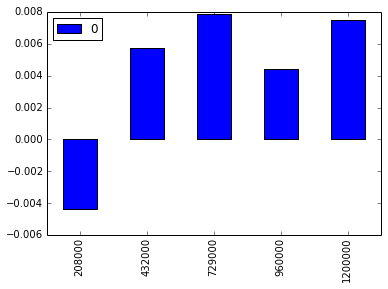

In [16]:
index = sorted(mean_diffs.keys())
pd.DataFrame([mean_diffs[f] for f in index], index=index).plot(kind='bar')

In [18]:
te.res_dir

'/home/brejac01/sources/lisa/results/20170327_153935'